#Similarities between associated genes in drug compounds

After compiling information on the genes associated with specific [drug compounds](https://raw.githubusercontent.com/dhimmel/drugbank/3e87872db5fca5ac427ce27464ab945c0ceb4ec6/data/drugbank-slim.tsv) , a [jaccard](https://en.wikipedia.org/wiki/Jaccard_index) was calculated for each pair of drugs. Additionally, the drugs were categorized in four subsets: target, carrier, transporter and enzyme. The combined jaccard values for each category were compared on a univariate level using a histogram and on a bivariate level with a hexbin scatterplot. The [compound similarity data](http://nbviewer.ipython.org/github/dhimmel/drugbank/blob/9eb1e15ada5e6579e5aea1cae784c10602037b05/similarity.ipynb) for each pair of drugs was added as a fifth subset to compare the chemical makeup of the drugs in relation to the categories. A multi-lined pointplot was also created to demonstrate the relationship between compound similarity and mean jaccard value. Using 0.5 as a baseline value, the compound similarity values were converted into contingency values and used with the category jaccard values to create contingency tables for each pair of drug compounds. Finally, the contingency relative frequency for each combination of category was illustrated with five barplots.

In [1]:
import itertools
import math
import gzip

import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy
import scipy

%matplotlib inline

In [2]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6' #commit code is unique to this data

# Read subset of DrugBank compounds
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/{}/data/drugbank-slim.tsv'.format(commit)
drugbank_df = pandas.read_table(url)
drugbank_df.head()

# Read protein-compound relationships
url = 'https://raw.githubusercontent.com/dhimmel/drugbank/{}/data/proteins.tsv'.format(commit)
protein_df = pandas.read_table(url)

# remove rows from protein_df whose drugbank_ids are not in the slim dataset
protein_df = protein_df[protein_df.drugbank_id.isin(drugbank_df.drugbank_id)]
categories = set(protein_df['category'])

In [3]:
def jaccard(set_0, set_1):
    """Jaccard index with two inputs set_0 and set_1"""
    set_0 = set(set_0)
    set_1 = set(set_1)
    total_number = len(set_0 | set_1)
    if total_number == 0:
        return 0
    return len(set_0 & set_1) / float(total_number)

In [4]:
#create dictionary with drugbank_id as key, category as value
#category is also key of inside dictionary with gene value
protein_dict = dict()

for (drugbank_id, category), df in protein_df.groupby(['drugbank_id', 'category']):
    category_dict = protein_dict.setdefault(drugbank_id, dict())
    category_dict[category] = set(df.entrez_gene_id)

In [5]:
rows= list()

for compound_0, compound_1 in itertools.combinations(protein_dict, 2):
    for category in categories:
        genes_0 = protein_dict[compound_0].get(category, set())
        genes_1 = protein_dict[compound_1].get(category, set())
        jc = jaccard(genes_0, genes_1)
        row = compound_0, compound_1, category, jc
        rows.append(row)

jaccard_df = pandas.DataFrame(rows, columns=['compound_0', 'compound_1', 'category', 'jaccard'])
jaccard_df.head()

,compound_0,compound_1,category,jaccard
0,DB00302,DB01247,enzyme,0
1,DB00302,DB01247,transporter,0
2,DB00302,DB01247,target,0
3,DB00302,DB01247,carrier,0
4,DB00302,DB00768,enzyme,0


In [6]:
jaccard_df = jaccard_df.set_index(['compound_0', 'compound_1', 'category']).unstack().jaccard.reset_index()
jaccard_df.head()

category,compound_0,compound_1,carrier,enzyme,target,transporter
0,DB00014,DB00035,0,0,0,0
1,DB00014,DB00050,0,0,1,0
2,DB00014,DB00104,0,0,0,0
3,DB00014,DB00117,0,0,0,0
4,DB00014,DB00118,0,0,0,0


In [26]:
#open and read the similarities table
path = '/Users/sabrinalchen/Downloads/similarity.tsv.gz'
similarities_df = pandas.read_table(path, header=True, names = ['compound_0', 'compound_1', 'similarity'])
similarities_df.head()

,compound_0,compound_1,similarity
0,DB05107,DB05105,0.0441
1,DB05107,DB05104,0.1457
2,DB05107,DB08423,0.1268
3,DB05107,DB05102,0.1000
4,DB05107,DB08421,0.1875


In [27]:
#merge the orginial contingency-type table 
spread_df = pandas.merge(jaccard_df, similarities_df)
spread_df.head()

category,compound_0,compound_1,carrier,enzyme,target,transporter,similarity
0,DB00014,DB00104,0,0,0,0,0.4080
1,DB00014,DB00121,0,0,0,0,0.1212
2,DB00014,DB00122,0,0,0,0,0.0520
3,DB00014,DB00126,0,0,0,0,0.0919
4,DB00014,DB00129,0,0,0,0,0.0873


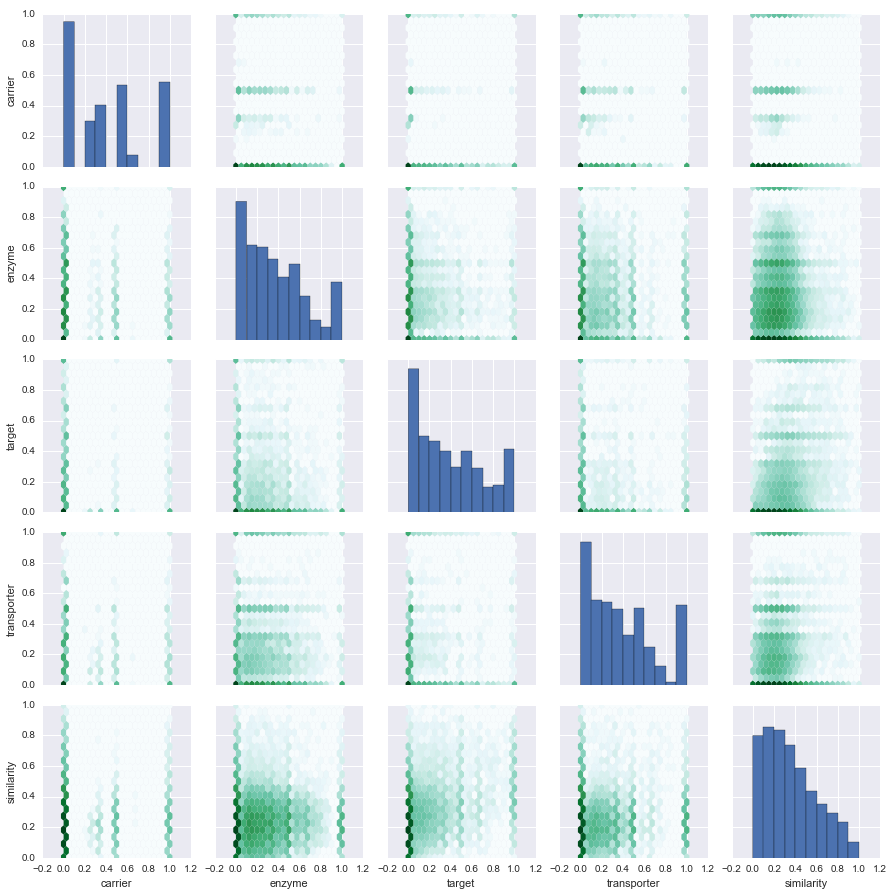

In [28]:
pandas.merge(jaccard_df, similarities_df)
g = seaborn.PairGrid(spread_df, diag_sharey = False, palette = "Set2")
g.map_offdiag(plt.hexbin, cmap = "BuGn", gridsize = 20, bins = "log", edgecolor = 'none')
g.map_diag(plt.hist, log = True)
g.savefig("figure/similarity.png", dpi = 200)

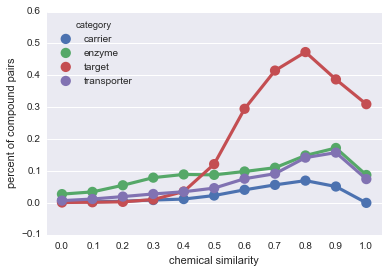

In [37]:
#CREATE THE JACCARD MEAN VS SIMILARITY GRAPH

#create column for rounded similarity
spread_df['rounded_similarity'] = spread_df['similarity'].round(decimals = 1)

#group the dataframe by the column for rounded similarity
grouped = spread_df.groupby('rounded_similarity', sort = True)

#sort each section into the means of the jaccard 
grouped = grouped.mean()

#drop the "similarity column" in preparation for graphing
grouped.drop('similarity', axis = 1, inplace = True)

#create an individul column for the index -- for graphing purposes
group=grouped.stack(0).reset_index(1)
group['index1'] = group.index

#rename the dataframe columns
group.columns = ['category', 'jaccard', 'similarity']

similarity_mean = seaborn.pointplot(x = 'similarity', y = 'jaccard', hue = 'category', data = group)
fig = similarity_mean.get_figure()
plt.xlabel('chemical similarity')
plt.ylabel('percent of compound pairs')
fig.savefig('figure/similarity_mean.png')

In [20]:
#change the vales in the similarity column to contingency values
simi_cont_df = ((spread_df.loc[:,'similarity'] < 0.5) == 0).astype(int)
simi_cont_df = ((spread_df.loc[:,'similarity'] > 0.5) == 1).astype(int)
spread_df.similarity = simi_cont_df
spread_df.head()

category,compound_0,compound_1,carrier,enzyme,target,transporter,similarity
0,DB00014,DB00104,0,0,0,0,0
1,DB00014,DB00121,0,0,0,0,0
2,DB00014,DB00122,0,0,0,0,0
3,DB00014,DB00126,0,0,0,0,0
4,DB00014,DB00129,0,0,0,0,0


In [11]:
#delete the compound_0 and compound_1
spread_df = spread_df[['enzyme', 'target', 'carrier', 'transporter', 'similarity']]
spread_df.head()

category,enzyme,target,carrier,transporter,similarity
0,0,0,0,0,False
1,0,0,0,0,False
2,0,0,0,0,False
3,0,0,0,0,False
4,0,0,0,0,False


In [12]:
def contingency_table(df):
    """create a contingency table for a dataframe"""
    a = df.iloc[:, 0] > 0
    b = df.iloc[:, 1] > 0
    df = df.groupby([a, b]).count()
    df = df[[0]].unstack()
    df.reset_index(drop = True)
    df.index = ['False', 'True']
    df.stack().unstack()
    return df

In [13]:
#make a dictionary of each combination of tuples with the contingency table and p-value as keys
contingency_dict = {}
for pair in itertools.permutations(spread_df.columns, 2):
    pair_df = spread_df[list(pair)]
    cont_table = contingency_table(pair_df)
    chi2, p, dof, ex = scipy.stats.chi2_contingency(cont_table)
    contingency_dict[pair] = {'contingency_table': cont_table, 'p-value': p, 'chi2': chi2}

In [14]:
freq_dict = {}
true_list = []
false_list = []
key_list1 = []
key_list2 = []
for key in contingency_dict:
    a = contingency_dict[key]['contingency_table']
    false, true = a.iloc[1, :].values / a.sum(axis=0).values
    true_list.append(true)
    false_list.append(false)
    list(key)
    key_list1.append(key[0])
    key_list2.append(key[1])
    freq_dict["True"] = true_list  #add all true frequencies to the true_list
    freq_dict["False"] = false_list  #add all false frequences to the false_list
    freq_dict["Type1"] = key_list1
    freq_dict["Type2"] = key_list2

In [15]:
freq_df = pandas.DataFrame(data = freq_dict)
freq_df = freq_df[["Type1", 'Type2', 'True', 'False']]

In [16]:
freq_df = pandas.melt(freq_df, id_vars = ['Type1', 'Type2'], value_vars = ['True', 'False'])
freq_df.columns = ['Type1', 'Type2', 'T_or_F', 'contingency_relative_frequency']
freq_df['contingency_relative_frequency'] = freq_df['contingency_relative_frequency']*100
freq_df = freq_df.iloc[::-1]
freq_df.head()

,Type1,Type2,T_or_F,contingency_relative_frequency
39,transporter,carrier,False,4.970793
38,target,transporter,False,2.408341
37,carrier,enzyme,False,0.577222
36,enzyme,similarity,False,19.167300
35,similarity,carrier,False,0.481979


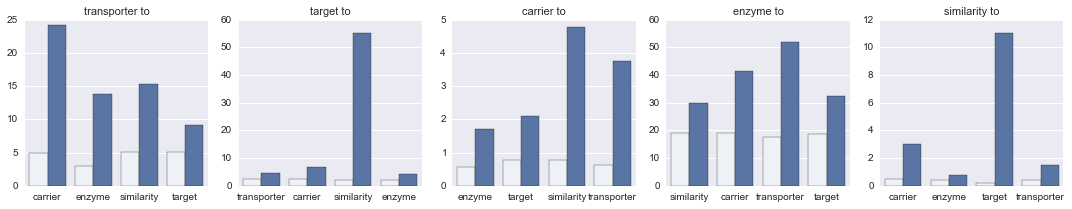

In [21]:
# Initialize a grid of plots with an Axes for each walk
grid = seaborn.FacetGrid(freq_df,  col = "Type1", sharex = "none", sharey = "none")
grid = grid.map_dataframe(seaborn.barplot, x = 'Type2', y = 'contingency_relative_frequency', hue = 'T_or_F').set_titles("{col_name} to")
grid.savefig("figure/output.png", dpi = 200)